In [4]:
from preprocessor import *
from recommender import *

import pandas as pd
import numpy as np

import networkx as nx
from stellargraph import StellarGraph
from stellargraph.mapper import Attri2VecNodeGenerator, GraphSAGENodeGenerator

from sklearn.decomposition import PCA
from sklearn.manifold import TSNE

In [5]:
nodes = pd.read_csv("Dataset/nodes.csv")
nodes = nodes.set_index("Id")
alinks = pd.read_csv("Dataset/alinks.csv")
bilinks = pd.read_csv("Dataset/bilinks.csv")
clinks = create_clinks(bilinks,nodes)

### StellarGraph Machine Learning Model

In [6]:
node_data = nodes[["Group","Salesrank","AvgRating"]]
GroupCodes = {'Book': 0, 'DVD': 1, 'Music': 2, 'Video': 3}
node_data["GroupCode"] = node_data["Group"].apply(lambda x: GroupCodes[x])
node_data = node_data[["GroupCode","Salesrank","AvgRating"]]
node_data.sample(3)

/var/folders/_l/nyk3mgld6gl9lvm8gzrjd2pm0000gn/T/ipykernel_79571/1441484520.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  node_data["GroupCode"] = node_data["Group"].apply(lambda x: GroupCodes[x])


,GroupCode,Salesrank,AvgRating
Id,,,
282703,0,53588,4.5
541947,0,175650,4.0
495960,0,911788,0.0


In [4]:
### We will create a homogenous Graph among the products

In [5]:
graph = StellarGraph({"product": node_data}, 
                            {"similar": alinks})
print(graph.info())

StellarGraph: Undirected multigraph
 Nodes: 542664, Edges: 275230

 Node types:
  product: [542664]
    Features: float32 vector, length 3
    Edge types: product-similar->product

 Edge types:
    product-similar->product: [275230]
        Weights: all 1 (default)
        Features: none


In [6]:
x_inp_a2v, x_out_a2v, history_a2v, model_a2v = attri2vec_model(G=graph, batch_size=1000, epochs=5)

Generate samples ...
Attri2vec model ...
link_classification: using 'ip' method to combine node embeddings into edge embeddings
Keras model ...
Train the model ...
Epoch 1/5


2023-07-21 12:21:47.441717: W tensorflow/core/platform/profile_utils/cpu_utils.cc:128] Failed to get CPU frequency: 0 Hz


3558/3558 [==============================] - 171s 48ms/step - loss: 0.6969 - binary_accuracy: 0.4947
Epoch 2/5
3558/3558 [==============================] - 174s 49ms/step - loss: 0.6970 - binary_accuracy: 0.5050
Epoch 3/5
3558/3558 [==============================] - 174s 49ms/step - loss: 0.6997 - binary_accuracy: 0.5084
Epoch 4/5
3558/3558 [==============================] - 175s 49ms/step - loss: 0.6988 - binary_accuracy: 0.5109
Epoch 5/5
3558/3558 [==============================] - 178s 50ms/step - loss: 0.6987 - binary_accuracy: 0.5139


In [8]:
node_embeddings_a2v = generate_embeddings(features=node_data, 
generator=Attri2VecNodeGenerator(G=graph,batch_size=1000), x_inp_src=x_inp_a2v[0], x_out_src = x_out_a2v[0])

543/543 [==============================] - 0s 377us/step


<Figure size 700x700 with 0 Axes>

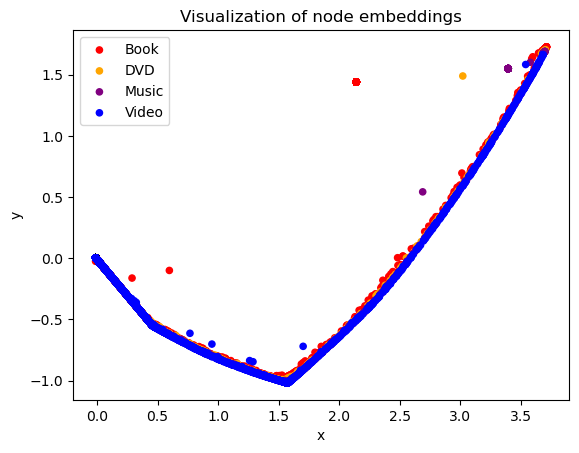

In [9]:
plot_embeddings(node_embeddings_a2v, node_data.GroupCode, PCA(n_components=2))

###  GraphSage Model

In [12]:
x_inp_gs, x_out_gs, history_gs, model_gs = graphsage_model(G=graph,
                                                           batch_size=1000, 
                                                           epochs = 2)

Generate samples ...
GraphSAGE model ...
link_classification: using 'ip' method to combine node embeddings into edge embeddings
Keras model ...
Train ...
Epoch 1/2
3558/3558 [==============================] - 491s 138ms/step - loss: 0.7286 - binary_accuracy: 0.5573
Epoch 2/2
3558/3558 [==============================] - 480s 135ms/step - loss: 0.7283 - binary_accuracy: 0.5579


In [13]:
node_embeddings_gs = generate_embeddings(features=node_data, 
generator=GraphSAGENodeGenerator(G=graph,batch_size=100,num_samples=[5, 3]),x_inp_src=x_inp_gs[0::2], x_out_src=x_out_gs[0])

5427/5427 [==============================] - 26s 5ms/step


### Plotting Embeddings using PCA

<Figure size 700x700 with 0 Axes>

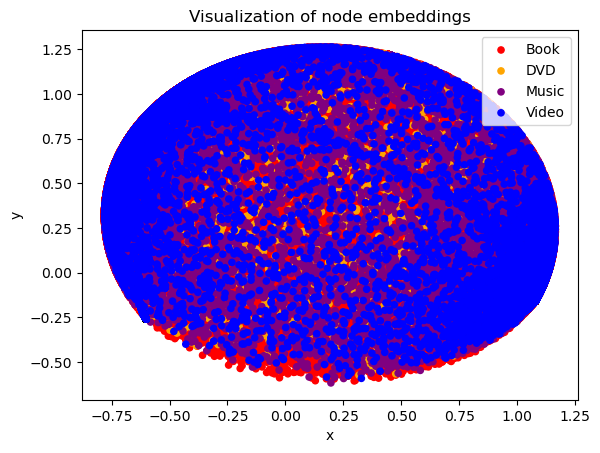

In [14]:
plot_embeddings(node_embeddings_gs,node_data.GroupCode,PCA(n_components=2))

### Plotting Embeddings using TSNE

<Figure size 700x700 with 0 Axes>

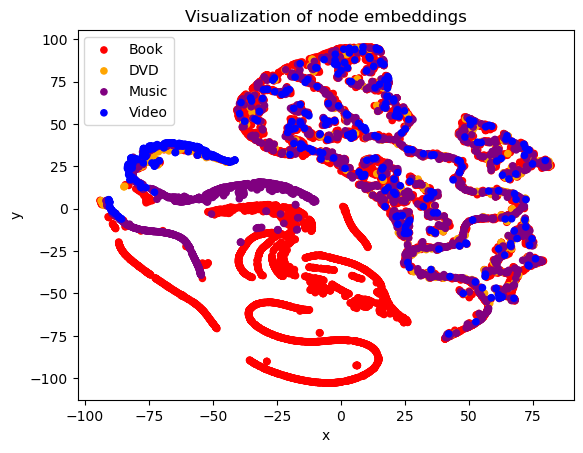

In [15]:
plot_embeddings(node_embeddings_gs[:10000,:], node_data.GroupCode.values[:10000],
                TSNE(n_components=2))

### Saving Embedding Weights

In [16]:
X_GraphSAGE = pd.DataFrame(data=node_embeddings_gs,index=node_data.index)
X_Attri2vec = pd.DataFrame(data=node_embeddings_a2v,index=node_data.index)

In [17]:
X_GraphSAGE.to_csv("Model/X_GRAPHSAGE.csv")
X_Attri2vec.to_csv("Model/X_ATTRI2VEC.csv")

### Sample Predictions

In [12]:
X_GraphSAGE=pd.read_csv("./ModelData/X_GRAPHSAGE.csv").set_index("Id")
X_Attri2vec=pd.read_csv("./ModelData/X_ATTRI2VEC.csv").set_index("Id")
nodes = pd.read_csv("Dataset/nodes.csv")

In [29]:
products=[325,291]

In [30]:
metrics = ['minkowski']#,'manhattan','canberra']
embs = {"GraphSAGE": X_GraphSAGE}
for product in products:
    for emb in embs: 
        for metric in metrics:
            print(product, f"{nodes.loc[product,'Group']} '{nodes.loc[product,'Title']}':")
            print(f"{emb} embeddings: distance metric {metric}")
            recommender([product],
                                  no_recommendations=5, 
                                  embeddings_df=embs[emb], 
                                  nodes_df=nodes, 
                                  metric=metric)
            print("")

325 Book 'Star Power for Preschoolers: Learning Life Skills Through Physical Play':
GraphSAGE embeddings: distance metric minkowski
For product Book 'Star Power for Preschoolers: Learning Life Skills Through Physical Play' we recommend: 
1. Book 'Standards : Trumpet Transcriptions With Piano Score';
2. Book 'The Mind of a Savant: Language Learning and Modularity';
3. Book 'Welcome to the Catholic Church';
4. Book 'Anakin Skywalker (Star Wars - Novelty Shape Books, 1)';
5. Book 'Color 'Em Book';

291 Book 'How To Incorporate and Start a Business in North Carolina':
GraphSAGE embeddings: distance metric minkowski
For product Book 'How To Incorporate and Start a Business in North Carolina' we recommend: 
1. Book 'The Java FAQ';
2. Book 'Windows 2000 Security Little Black Book: The Hands-On Reference Guide for Establishing a Secure Windows 2000 Network';
3. Book 'Grim Fandango: Prima's Official Strategy Guide';
4. Book 'Coming Home To Jerusalem: A Personal Journey';
5. Book 'Golden Hours :

### Similar Items based on Jaccards Similarity

In [27]:
G = nx.from_pandas_edgelist(alinks, source='source', target='target')
missing_nodes = list(set(nodes.index)-set(G.nodes()))
len(missing_nodes)
G.add_nodes_from(missing_nodes)

In [38]:
#Similarity based 
node_ids = list(G.nodes())
similarity = pd.DataFrame(index=node_ids)
for product in products:
    jaccards = [list(nx.jaccard_coefficient(G,[(product,idx)]))[0][2] for idx in node_ids]
    similarity[f'{product}_jaccards'] = jaccards
print_sim_products(nodes_df=nodes, similarity_df=similarity, max_similars=10)

Product Book 'The Prince':
Metric jaccards: 
1. Book 'The Prince': 1.0
2. Book 'Reformers in the Wings: From Geiler Von Kaysersberg to Theodore Beza': 0.014492753623188406
3. Book 'Nicomachean Ethics (Dover Thrift Editions)': 0.014492753623188406
4. Book 'The Prince': 0.014492753623188406
5. Book 'The Prince': 0.014492753623188406
6. Book 'The Book of Five Rings': 0.014492753623188406
7. Book 'On War': 0.014492753623188406
8. Book 'The Prince (Dover Thrift Editions)': 0.014492753623188406
9. Book 'Why We Win': 0.014492753623188406
10. Book 'A Book of Five Rings': 0.014492753623188406
